# Dealing with problems having side-constraints
In this notebook, we illustrate how to define a constrained problem and how it can be solved using NSGA-II. We assume that the concepts included in the ``Defining problems`` notebook have been assimilated.

## Defining a constrained problem
We use an example the problem known as Srinivas, which has the following formulation (see [DPA02](https://doi.org/10.1109/4235.996017)):
):


\begin{align}
f_1(\vec{x}) & = (x_1 - 2)^2 + (x_2 - 1)^2 + 2 \\
f_2(\vec{x}) & = 9x_1 - (x_2 - 1)^2 \\
g_1(\vec{x}) & = 1.0 - (x_1^2 + x_2^2) / 225.0 \\
g_2(\vec{x}) & = (3.0 * x_2 - x_1) / 10.0 - 1.0 \\
x & \in [-20, 20]
\end{align}


This problem is implemented in MetaJul in the following function:
```julia
function srinivas()
  problem = ContinuousProblem{Float64}("Srinivas")

  addVariable(problem, Bounds{Float64}(-20.0, 20.0))
  addVariable(problem, Bounds{Float64}(-20.0, 20.0))

  f1 = x ->  2.0 + (x[1] - 2.0) * (x[1] - 2.0) + (x[2] - 1.0) * (x[2] - 1.0)
  f2 = x -> 9.0 * x[1] - (x[2] - 1.0) * (x[2] - 1.0)

  addObjective(problem, f1)
  addObjective(problem, f2)

  c1 = x -> 1.0 - (x[1] * x[1] + x[2] * x[2]) / 225.0
  c2 = x -> (3.0 * x[2] - x[1]) / 10.0 - 1.0

  addConstraint(problem, c1)
  addConstraint(problem, c2)

  return problem
end
```

We can observe that the problem formulation includes two constraints. We use the NSGA-II approach to deal with side constraints, in which every constraint must be expressed as an inequality of type `expression >=0.0`. This way, when `expression < 0.0` then it is considered as a constraint violation, and the overall constraint violation degree will the sum of the values of the constraints array. If that value is negative, then the solution is infeasible.


## Solving a constrained problem with NSGA-II
We use now NSGA-II to solve the problem. The only difference with solving unconstrained problems is that we need to indicate a dominance comparator using the ``compareForConstraintsAndDominance`` function. Thus, when comparing two solutions by dominance, a prior check is made to compare them according to their degree of constraint violation.

In [1]:
using MetaJul

problem = srinivas()

termination = TerminationByEvaluations(25000)

mutation = PolynomialMutation(probability = 1.0 / numberOfVariables(problem), distributionIndex = 20.0, bounds = problem.bounds)

crossover = SBXCrossover(probability = 1.0, distributionIndex = 20.0, bounds = problem.bounds)

solver::NSGAII = NSGAII(problem, populationSize=100,termination=termination, mutation=mutation, crossover=crossover) ;

solver.dominanceComparator = ConstraintsAndDominanceComparator() ;

In [5]:
optimize!(solver) ;

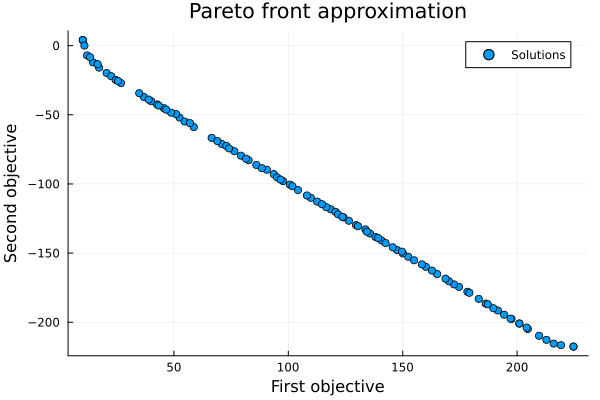

In [6]:
using Plots
 
#data to plot
x = [solution.objectives[1] for solution in foundSolutions(solver)];
y = [solution.objectives[2] for solution in foundSolutions(solver)];
 
gr();
 
scatter(x, y,  title = "Pareto front approximation", label = "Solutions")
xlabel!("First objective")
ylabel!("Second objective")